# Build your dream team: Perform Research with Multi-Agent Group Chat

AutoGen provides a general conversation pattern called group chat, which involves more than two agents. The core idea of group chat is that all agents contribute to a single conversation thread and share the same context. This is useful for tasks that require collaboration among multiple agents.

## Requirements

AutoGen requires `Python>=3.8`

In [35]:
#%pip install pyautogen

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [4]:
import autogen
from autogen.agentchat.contrib.capabilities.teachability import Teachability
from autogen.agentchat import ConversableAgent,UserProxyAgent,AssistantAgent,GroupChat,GroupChatManager
from autogen.oai.openai_utils import config_list_from_json
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()
config_list_gpt4 = config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt4o"],# in this example we used gpt4 omni
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well).

You can set the value of config_list in any way you prefer. 

## Construct Agents

In [5]:
gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt4,
    "timeout": 120,
}

Let's build our team, this code is setting up a system of agents using the autogen library. The agents include a human admin, an AI Developer, a scientist, a planner, an executor, and a quality assurance agent. Each agent is configured with a name, a role, and specific behaviors or responsibilities.

In [10]:
# User Proxy Agent  
user_proxy = UserProxyAgent(  
    name="Admin",  
    human_input_mode="ALWAYS",  
    system_message="1. A human admin. 2. Interact with the team. 3. Plan execution needs to be approved by this Admin.",  
    code_execution_config=False,  
    llm_config=gpt4_config,  
    description="""Call this Agent if:   
        You need guidance.
        The program is not working as expected.
        You need api key                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  
# Assistant Agent - Developer  
developer = AssistantAgent(  
    name="Developer",  
    llm_config=gpt4_config,  
    system_message="""You are an AI developer. You follow an approved plan, follow these guidelines: 
    1. You write python/shell code to solve tasks. 
    2. Wrap the code in a code block that specifies the script type.   
    3. The user can't modify your code. So do not suggest incomplete code which requires others to modify.   
    4. You should print the specific code you would like the executor to run.
    5. Don't include multiple code blocks in one response.   
    6. If you need to import libraries, use ```bash pip install module_name```, please send a code block that installs these libraries and then send the script with the full implementation code 
    7. Check the execution result returned by the executor,  If the result indicates there is an error, fix the error and output the code again  
    8. Do not show appreciation in your responses, say only what is necessary.    
    9. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
    """,  
    description="""Call this Agent if:   
        You need to write code.                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  #, don't use "!pip install" in the code block. use "pip install
# Assistant Agent - Planner  
planner = AssistantAgent(  
    name="Planner",  #2. The research should be executed with code
    system_message="""You are an AI Planner,  follow these guidelines: 
    1. Your plan should include 5 steps, you should provide a detailed plan to solve the task.
    2. Post project review isn't needed. 
    3. Revise the plan based on feedback from admin and quality_assurance.   
    4. The plan should include the various team members,  explain which step is performed by whom, for instance: the Developer should write code, the Executor should execute code, important do not include the admin in the tasks e.g ask the admin to research.  
    5. Do not show appreciation in your responses, say only what is necessary.  
    6. The final message should include an accurate answer to the user request
    """,  
    llm_config=gpt4_config,  
    description="""Call this Agent if:   
        You need to build a plan.                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  
# User Proxy Agent - Executor  
executor = UserProxyAgent(  
    name="Executor",  
    system_message="1. You are the code executer. 2. Execute the code written by the developer and report the result.3. you should read the developer request and execute the required code",  
    human_input_mode="NEVER",  
    code_execution_config={  
        "last_n_messages": 20,  
        "work_dir": "dream",  
        "use_docker": True,  
    },  
    description="""Call this Agent if:   
        You need to execute the code written by the developer.  
        You need to execute the last script.  
        You have an import issue.  
        DO NOT CALL THIS AGENT IF:  
        You need to modify code""",
)
quality_assurance = AssistantAgent(
    name="Quality_assurance",
    system_message="""You are an AI Quality Assurance. Follow these instructions:
      1. Double check the plan, 
      2. if there's a bug or error suggest a resolution
      3. If the task is not solved, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach.""",
    llm_config=gpt4_config,
)

Group chat is a powerful conversation pattern, but it can be hard to control if the number of participating agents is large. AutoGen provides a way to constrain the selection of the next speaker by using the allowed_or_disallowed_speaker_transitions argument of the GroupChat class.

In [11]:
allowed_transitions = {
    user_proxy: [ planner,quality_assurance],
    planner: [ user_proxy, developer, quality_assurance],
    developer: [executor,quality_assurance, user_proxy],
    executor: [developer],
    quality_assurance: [planner,developer,executor,user_proxy],
}

In [12]:
system_message_manager="You are the manager of a research group your role is to manage the team and make sure the project is completed successfully."
groupchat = GroupChat(
    agents=[user_proxy, developer, planner, executor, quality_assurance],allowed_or_disallowed_speaker_transitions=allowed_transitions,
    speaker_transitions_type="allowed", messages=[], max_round=30,send_introductions=True
)
manager = GroupChatManager(groupchat=groupchat, llm_config=gpt4_config, system_message=system_message_manager)

Sometimes it's a bit complicated to understand the relationship between the entities, here we print a graph representation of the code


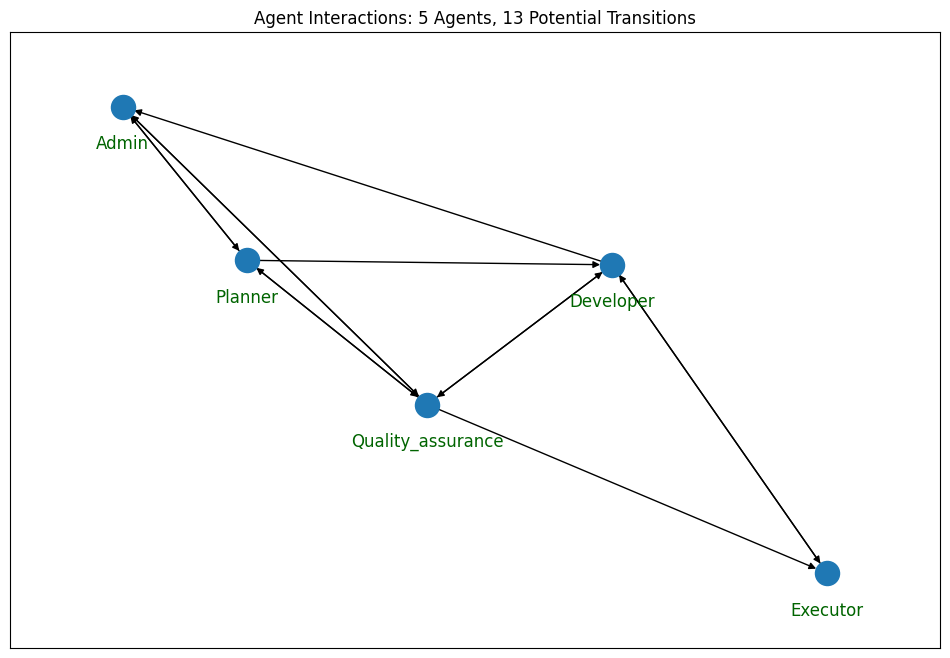

In [14]:
    
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
G.add_nodes_from([agent.name for agent in groupchat.agents])

# Add edges
for key, value in allowed_transitions.items():
    for agent in value:
        G.add_edge(key.name, agent.name)

# Set the figure size
plt.figure(figsize=(12, 8))

# Visualize
pos = nx.spring_layout(G)  # For consistent positioning

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# Draw labels below the nodes
label_pos = {k: [v[0], v[1] - 0.1] for k, v in pos.items()}  # Shift labels below the nodes
nx.draw_networkx_labels(G, label_pos, verticalalignment='top', font_color="darkgreen")

# Adding margins
ax = plt.gca()
ax.margins(0.1)  # Increase the margin value if needed


# Adding a dynamic title
total_transitions = sum(len(v) for v in allowed_transitions.values())
title = f'Agent Interactions: {len(groupchat.agents)} Agents, {total_transitions} Potential Transitions'
plt.title(title)

plt.show()

## Start Chat

In [15]:
task1="what are the 5 leading GitHub repositories on llm for the legal domain?"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task1
, clear_history=True
)

Admin (to chat_manager):

what are the 5 leading GitHub repositories on llm for the legal domain?

--------------------------------------------------------------------------------
Planner (to chat_manager):

To identify the 5 leading GitHub repositories on large language models (LLM) for the legal domain, we will follow a structured plan. Here is the detailed plan:

### Step 1: Define Search Criteria
**Team Member:** Planner
- Define the criteria for what constitutes a "leading" GitHub repository. This could include factors such as the number of stars, forks, recent activity, and relevance to the legal domain.

### Step 2: Conduct Initial Search
**Team Member:** Developer
- Use GitHub's search functionality to find repositories related to LLMs in the legal domain.
- Apply filters based on the criteria defined in Step 1.

### Step 3: Compile and Analyze Data
**Team Member:** Developer
- Compile a list of the top 10 repositories based on the initial search.
- Analyze these repositories t

In [16]:
task2="find the 3 most popular articles on gen ai for legal domain in the last month based on bing search, create a  markdown table"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task2
, clear_history=False
)

Admin (to chat_manager):

find the 3 most popular articles on gen ai for legal domain in the last month based on bing search, create a  markdown table

--------------------------------------------------------------------------------
Planner (to chat_manager):

To find the 3 most popular articles on generative AI for the legal domain in the last month based on Bing search, we will follow a structured plan. Here is the detailed plan:

### Step 1: Define Search Criteria
**Team Member:** Planner
- Define the criteria for what constitutes a "popular" article. This could include factors such as relevance, recency, and the number of shares or views.

### Step 2: Conduct Bing Search
**Team Member:** Developer
- Use Bing's search functionality to find articles related to generative AI in the legal domain from the last month.
- Apply filters based on the criteria defined in Step 1.

### Step 3: Compile and Analyze Data
**Team Member:** Developer
- Compile a list of the top 10 articles based on t

In [17]:
task3="based on techcrunch, please find 3 articles on companies developing llm for legal domain, that rasied seed round. please use serper api"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task3
, clear_history=False
)

Admin (to chat_manager):

based on techcrunch, please find 3 articles on companies developing llm for legal domain, that rasied seed round. please use serper api

--------------------------------------------------------------------------------
Planner (to chat_manager):

To find 3 articles on companies developing large language models (LLM) for the legal domain that have raised a seed round, based on TechCrunch, we will follow a structured plan. Here is the detailed plan:

### Step 1: Define Search Criteria
**Team Member:** Planner
- Define the criteria for what constitutes a relevant article. This could include factors such as the company developing LLMs for the legal domain and having raised a seed round.

### Step 2: Conduct Search Using Serper API
**Team Member:** Developer
- Use the Serper API to search for articles on TechCrunch related to companies developing LLMs for the legal domain that have raised a seed round.
- Apply filters based on the criteria defined in Step 1.

### St

In [ ]:
task4="based on the previous resources(github, bing, serper), please summerize the current state of llm for legal, and suggest a plan to contribute to the field, please save it as executive_summary.pdf"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task4
, clear_history=False
)

In [ ]:
import pprint
pprint.pprint(chat_result.cost)
pprint.pprint(chat_result.summary)
pprint.pprint(chat_result.chat_history)

You can reset the agents:

In [ ]:
for agent in groupchat.agents:
    agent.reset()